#### Импортирование библиотек

In [3]:
from datetime import datetime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.preprocessing import normalize

%matplotlib inline

#### Путь к модели с весами .cbm и к данным .txt

In [10]:
PATH_TO_MODEL = "catboost2736.cbm"
PATH_TO_DATA = "image_tumor_patient25022020_633nm.txt"

#### Загрузка данных

In [11]:
df = pd.read_csv(
    PATH_TO_DATA,
    sep="\t",
    skiprows=[0],
    header=None,
    names=["X", "Y", "Wave", "Intensity"],
)

num_of_samples = int(len(df) / df["Wave"].nunique())
X = [
    df[["Intensity"]][
        i * df["Wave"].nunique():(i + 1) * df["Wave"].nunique()
    ].to_numpy()
    for i in range(num_of_samples)
]
X = np.asarray(X)
X = X.reshape(num_of_samples, df["Wave"].nunique())
X = normalize(X)

print(f"Передано образцов: {num_of_samples}")

Передано образцов: 468


#### Модель

In [12]:
model = CatBoostClassifier(
    random_seed=42,
    iterations=700,
    loss_function="CrossEntropy",
    verbose=False,
)
model.load_model(PATH_TO_MODEL)

#### Предсказания для переданных данных: 

0 - здоровый, 1 - больной

In [13]:
predictions = model.predict(X)
print(predictions)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


#### Вероятности для каждого предсказания

In [14]:
predictions_probs = model.predict_proba(X)
print(predictions_probs[:20])

[[0.03644746 0.96355254]
 [0.07462532 0.92537468]
 [0.08120238 0.91879762]
 [0.05476734 0.94523266]
 [0.02642916 0.97357084]
 [0.07456314 0.92543686]
 [0.02461543 0.97538457]
 [0.02936668 0.97063332]
 [0.0034452  0.9965548 ]
 [0.0328558  0.9671442 ]
 [0.02460467 0.97539533]
 [0.19786439 0.80213561]
 [0.02698622 0.97301378]
 [0.02139266 0.97860734]
 [0.02728838 0.97271162]
 [0.12924708 0.87075292]
 [0.05022712 0.94977288]
 [0.05093202 0.94906798]
 [0.04761708 0.95238292]
 [0.3580032  0.6419968 ]]


#### График и предсказание для каждого образца

PredProb: [0.04 0.96]


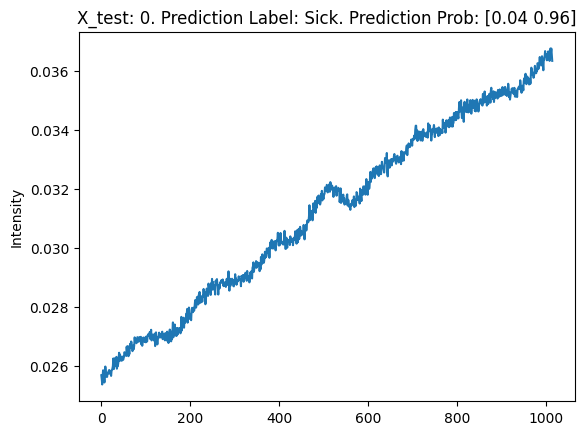

PredProb: [0.07 0.93]


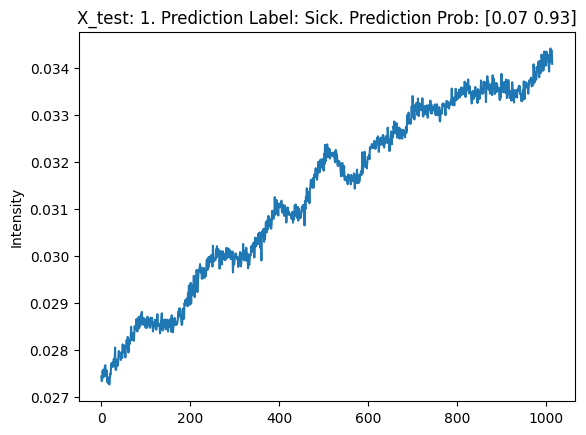

PredProb: [0.08 0.92]


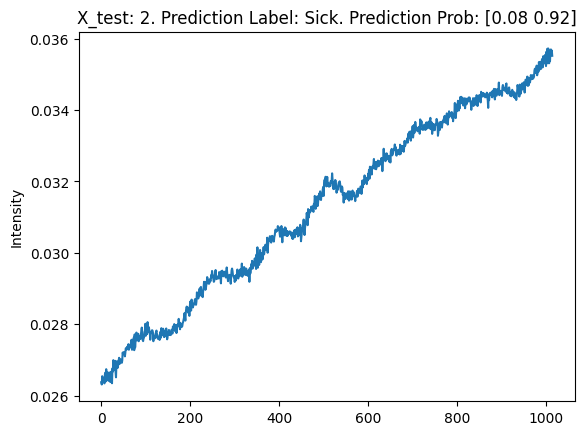

PredProb: [0.05 0.95]


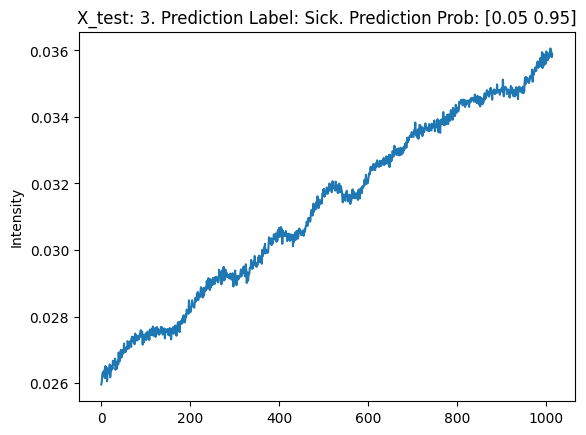

PredProb: [0.03 0.97]


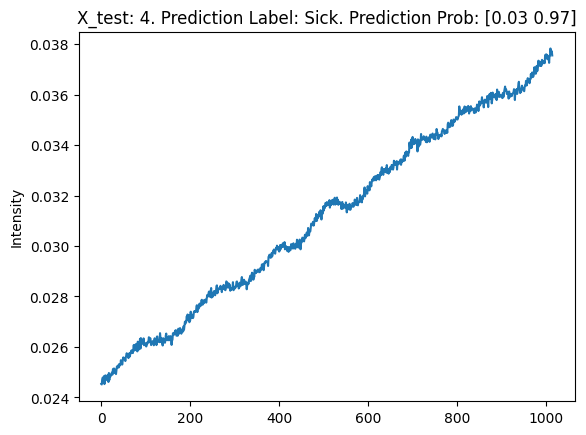

PredProb: [0.07 0.93]


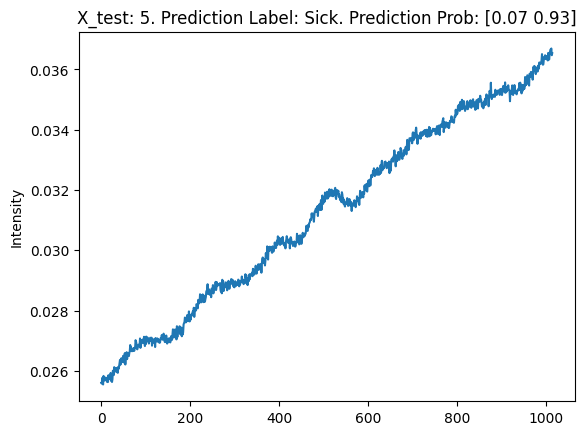

PredProb: [0.02 0.98]


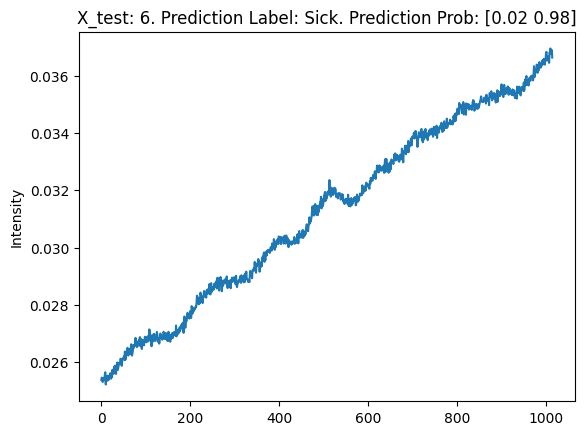

PredProb: [0.03 0.97]


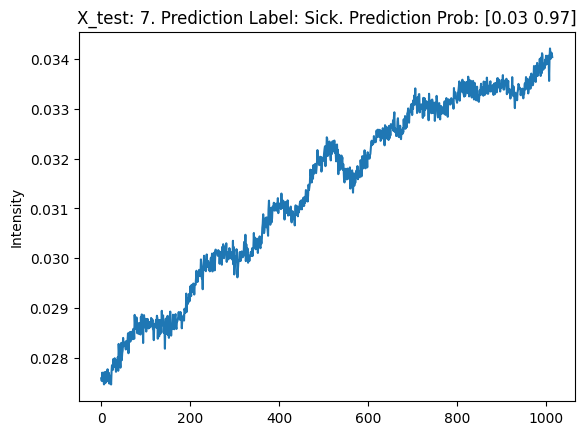

PredProb: [0. 1.]


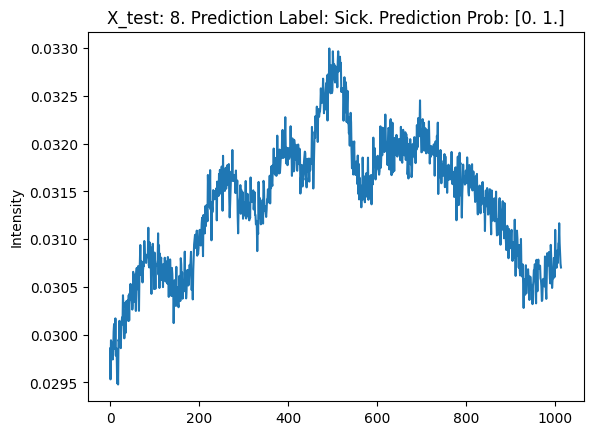

PredProb: [0.03 0.97]


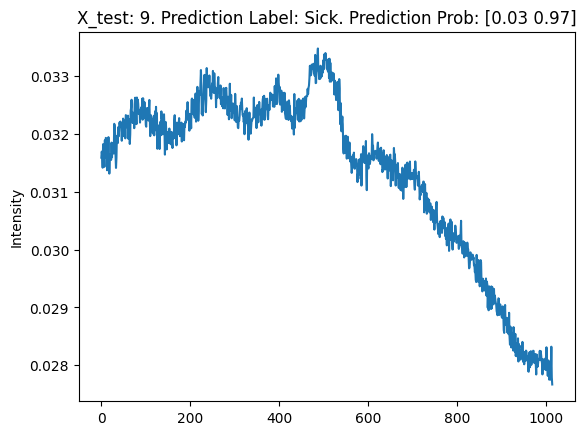

PredProb: [0.02 0.98]


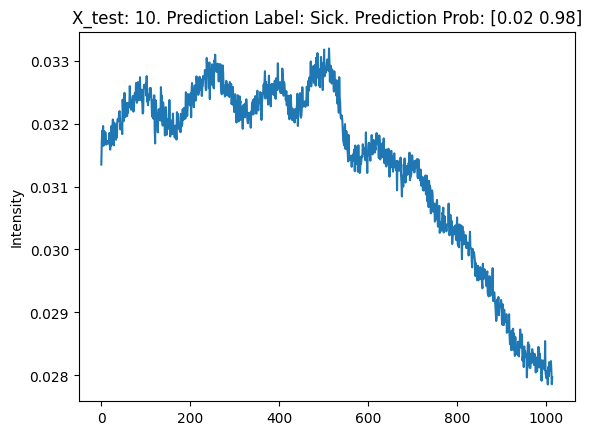

PredProb: [0.2 0.8]


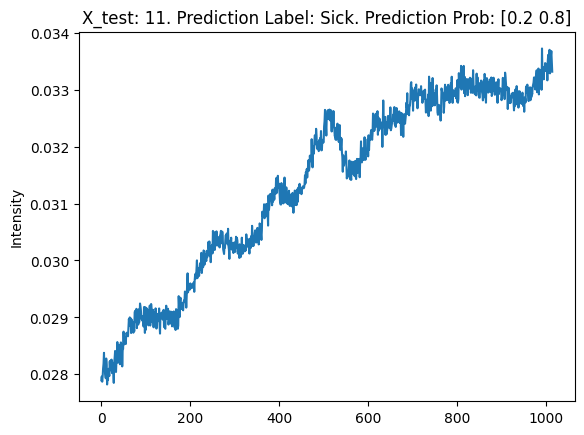

PredProb: [0.03 0.97]


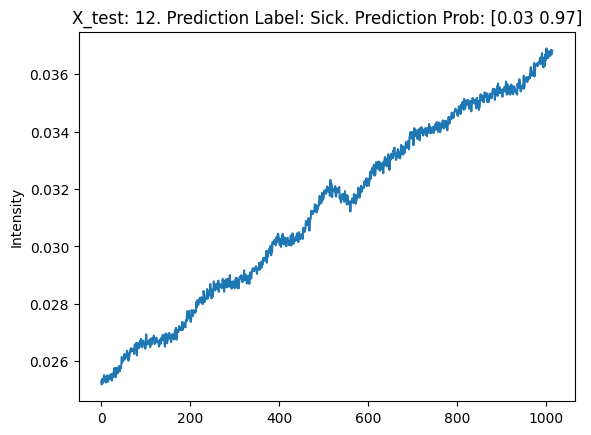

PredProb: [0.02 0.98]


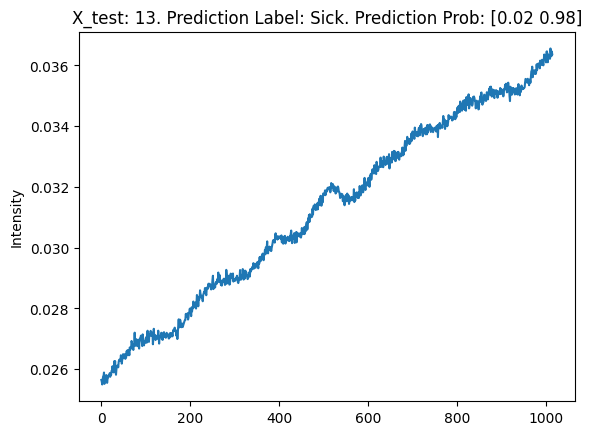

PredProb: [0.03 0.97]


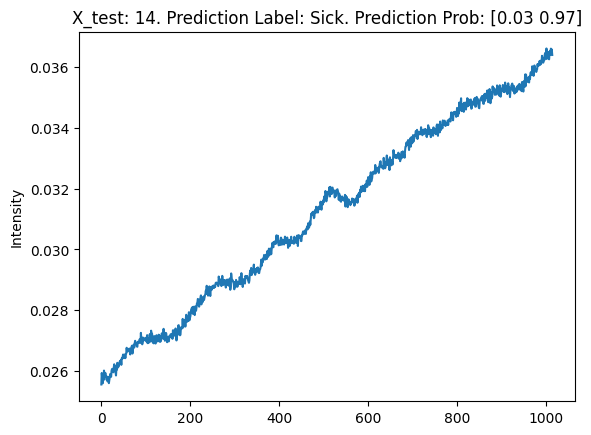

PredProb: [0.13 0.87]


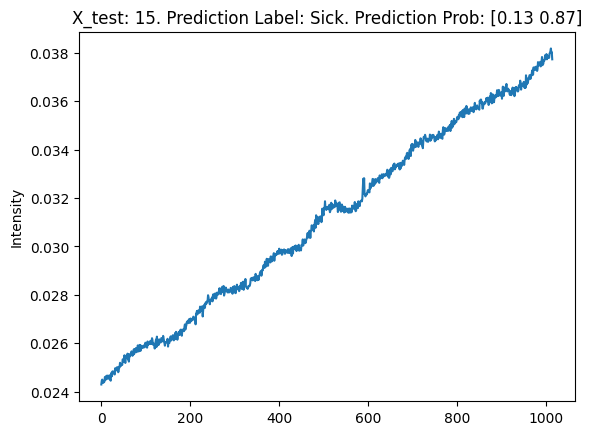

PredProb: [0.05 0.95]


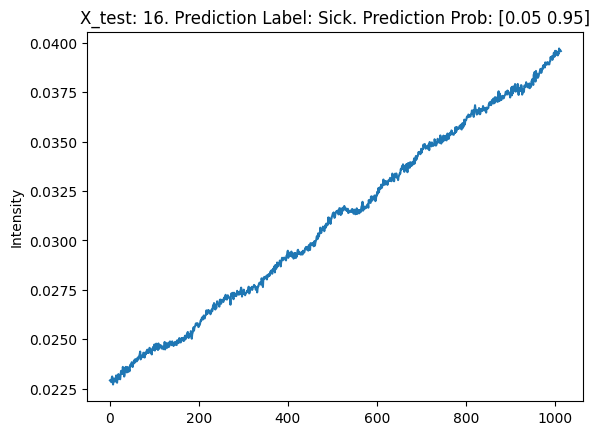

PredProb: [0.05 0.95]


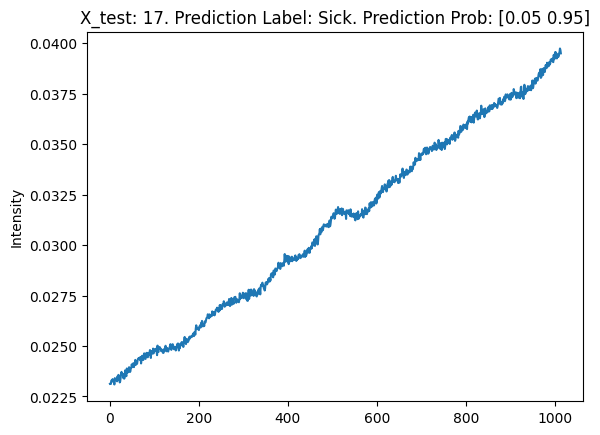

PredProb: [0.05 0.95]


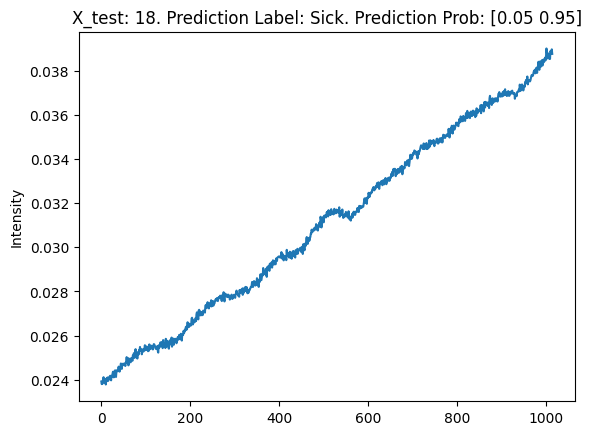

PredProb: [0.36 0.64]


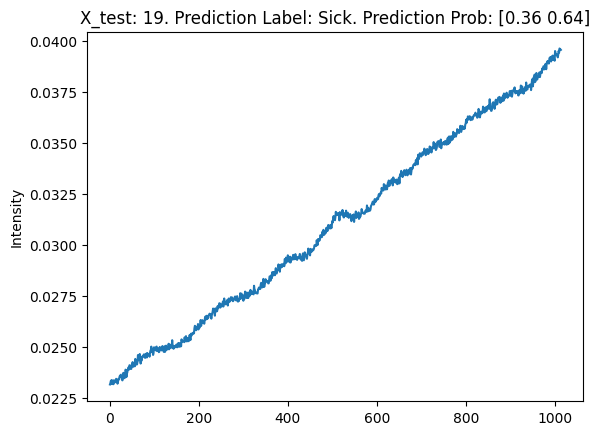

In [15]:
pred = model.predict_proba(X)
for i in range(20):
    print(f"PredProb: {np.round(pred,2)[i]}")
    label = "Sick" if pred[i].argmax() == 1 else "Helthy"
    plt.plot(X[i])
    plt.title(
        f"X_test: {i}. Prediction Label: {label}. Prediction Prob: {np.round(pred,2)[i]}"
    )
    plt.ylabel("Intensity")

    plt.show()

#### Сохранение предсказаний в txt file

In [83]:
# В формате label
predictions = model.predict(X)
output_file = f"labels_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.txt"
with open(output_file, "w") as outfile:
    for i in range(num_of_samples):
        outfile.write(f"{predictions[i]}\n")

In [84]:
# В формате id label
predictions = model.predict(X)
output_file = f"labels_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.txt"
with open(output_file, "w") as outfile:
    for i in range(num_of_samples):
        outfile.write(f"{i} {predictions[i]}\n")

In [106]:
# В формате X Y label
predictions = model.predict(X)
output_file = f"labels_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.txt"
with open(output_file, "w") as outfile:
    for i in range(num_of_samples):
        outfile.write(
            f"{df.iloc[i * df['Wave'].nunique()]['X']} "
            f"{df.iloc[i * df['Wave'].nunique()]['Y']} "
            f"{predictions[i]}\n"
        )

In [107]:
# В формате id X Y label
predictions = model.predict(X)
output_file = f"labels_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.txt"
with open(output_file, "w") as outfile:
    for i in range(num_of_samples):
        outfile.write(
            f"{i} {df.iloc[i * df['Wave'].nunique()]['X']} "
            f"{df.iloc[i * df['Wave'].nunique()]['Y']} "
            f"{predictions[i]}\n"
        )